In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
url_FPT = "https://drive.usercontent.google.com/download?id=1FVcbtZhX2L1bOJdDD-ib4ZbtyccV32sc&export=download&authuser=0&confirm=t&uuid=a280bc84-f83d-47fa-ac28-ccd0c0346e6e&at=APZUnTWbNOcXkgbN9Yp6rR3VbCDY:1719806602764"
url_PNJ = "https://drive.usercontent.google.com/download?id=1DWBkEGbX6-6ScrpveG-m2fMo0gMWhhOu&export=download&authuser=0&confirm=t&uuid=8ebde3ef-f77d-42d4-a032-d3d0611138c5&at=APZUnTX5Fvh08OIzHAFSZpGVuVyc:1719848161799"
url_VIC = "https://drive.usercontent.google.com/download?id=1RtknX7GIS_vO38Df4jJw2oRKMOy1hyjS&export=download&authuser=0&confirm=t&uuid=fab04af4-66d7-432b-bfc8-65dcae15e920&at=APZUnTUDyIjTYJYagjoGtSUIIlrx:1719848221485"
url_MSN = "https://drive.usercontent.google.com/download?id=1-18146kdUyB2ladSPfHcGFFT3G_wpD1k&export=download&authuser=0&confirm=t&uuid=caefdeab-3b5c-4ba0-ab52-6e18aa51b87e&at=APZUnTUqWhpA7y8suHJt_cQaBc8u:1719848202257"

In [3]:
df_FPT = pd.read_csv(url_FPT)

In [4]:
df_FPT.describe()

,Open,High,Low,Close,Volume,Open Interest
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0


In [5]:
#Function to visualize price of stock's price
def visualize_price(url):
  data = pd.read_csv(url)
  data['Date/Time'] = pd.to_datetime(data['Date/Time'])
  data.set_index('Date/Time', inplace=True)
  plt.figure(figsize=(12, 6))

  # Plot Open and Close prices
  plt.plot(data.index, data['Open'], label='Open Price')
  plt.plot(data.index, data['Close'], label='Close Price')
  plt.gca().spines[['top', 'right']].set_visible(False)

  plt.title('Open and Close Prices')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

In [6]:
def load_and_process_data(url):
    # Load data from the URL
    df = pd.read_csv(url)

    # Define target column and remove from the features
    target_column = df[['Close']]
    df = df.drop(columns=['Close'])

    # Convert Date column to datetime
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    df.set_index('Date/Time', inplace=True)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Volume']])

    # Convert back to DataFrame
    df_scaled = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Volume'], index=df.index)
    return df_scaled, target_column, scaler

def train_test_split(feature, target, test_size):
    #Calculate test size based on test_size parameter
    size = int(len(feature) * test_size)

    #Split data
    X_train = feature[size:]
    X_test = feature[:size]
    y_train = target[size:]
    y_test = target[:size]

    return X_train, X_test, y_train, y_test

def create_sequences(feature, target, seq_length):
    # Initialize empty lists to store the sequences and corresponding targets
    xs, ys = [], []

    # Loop through the dataset to create sequences of length seq_length
    for i in range(len(feature) - seq_length):
        # Extract a sequence of features starting from index i to i+seq_length
        x = feature[i:i + seq_length]

        # Extract the target value that comes right after the end of the sequence
        y = target[i + seq_length]

        # Append the sequence and the corresponding target to their respective lists
        xs.append(x)
        ys.append(y)

    # Convert the lists to numpy arrays and return them
    return np.array(xs), np.array(ys)

In [7]:
def create_model_LSTM(input_shape, output_size, neurons=30, activation_func='relu', dropout_rate=0.2, loss='mean_squared_error', optimizer='adam'):
    # Initialize a Sequential model
    model = Sequential()

    # Add the first LSTM layer with dropout regularization
    model.add(LSTM(neurons, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # Add the second LSTM layer without returning sequences
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dropout(dropout_rate))

    # Add a Dense layer with the specified activation function
    model.add(Dense(output_size, activation=activation_func))

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss=loss)
    return model


def train_model(model, X_train, y_train, validation_data, epochs=20, batch_size=32):
    # Train the model on the training data, validate with validation data
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

    return model, history


# Evaluate the model
def evaluate_model(model, X_test, y_test):
    # Predict the target values for the test data
    y_pred = model.predict(X_test)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Print the evaluation metrics
    print(f'MAE: {mae}, RMSE: {rmse}')
    return y_pred


# Plot predictions vs actual values
def plot_predictions(y_test, y_pred):
    # Create a plot to compare actual and predicted values
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, label='Actual Price Change')
    plt.plot(y_pred, label='Predicted Price Change')

    # Label the axes
    plt.xlabel('Numbers of price')
    plt.ylabel('Price Change')

    # Add a legend to distinguish between actual and predicted values
    plt.legend()

    # Display the plot
    plt.show()

In [8]:
def pipeline(url, seq_length):
    # Visualize the stock prices to understand the data better
    visualize_price(url)

    # Load and preprocess the data
    df_scaled, target_column, scaler = load_and_process_data(url)

    # Create sequences from the scaled data and target column
    X, y = create_sequences(df_scaled, target_column.values.flatten(), seq_length)

    # Split the sequences and targets into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Reshape the training and testing sets for LSTM input format [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    # Return the prepared datasets
    return X_train, X_test, y_train, y_test

In [9]:
seq_length = 60
output_size = 1

# Predict price of FPT's Stock

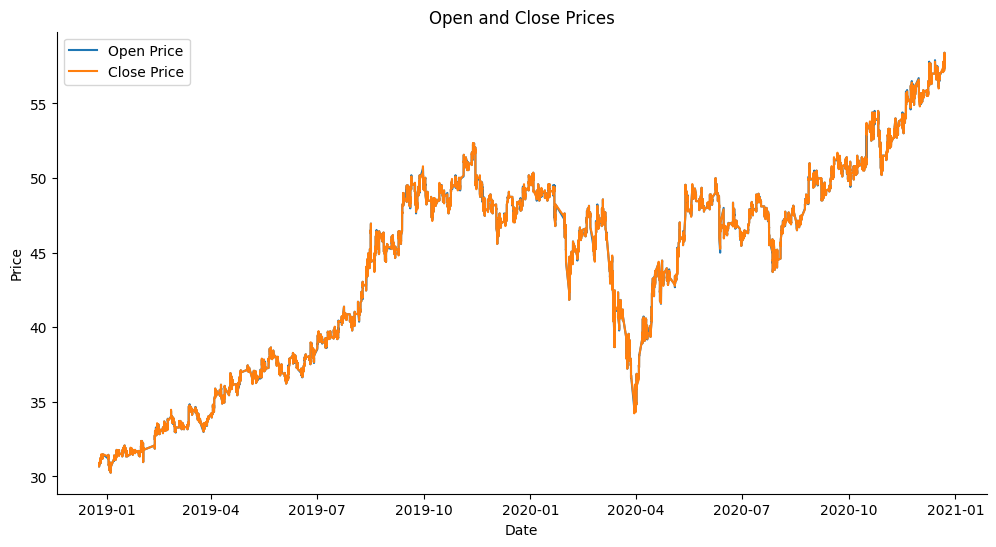

In [10]:
#Create data for training and validation model
X_train_FPT, X_test_FPT, y_train_FPT, y_test_FPT = pipeline(url_FPT, seq_length = 60)

In [11]:
input_shape = (seq_length, X_train_FPT.shape[2])

In [27]:
model_FPT = create_model_LSTM(input_shape, output_size) #Create model
model_FPT.summary()
model_FPT, history_FPT = train_model(model_FPT, X_train_FPT, y_train_FPT, validation_data=(X_test_FPT, y_test_FPT)) #Training model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 30)            4200      
                                                                 
 dropout_8 (Dropout)         (None, 60, 30)            0         
                                                                 
 lstm_9 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_9 (Dropout)         (None, 30)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 11551 (45.12 KB)
Trainable params: 11551 (45.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2434/24

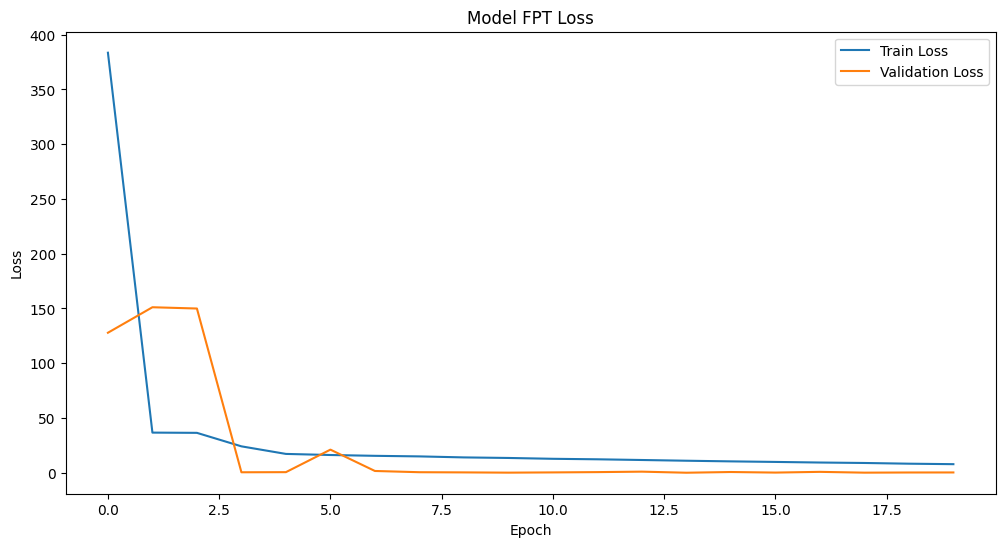

In [30]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_FPT.history['loss'], label='Train Loss')
plt.plot(history_FPT.history['val_loss'], label='Validation Loss')
plt.title('Model FPT Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize FPT price prediction

609/609 [==============================] - 3s 3ms/step
MAE: 0.392627894884388, RMSE: 0.5721448528534383


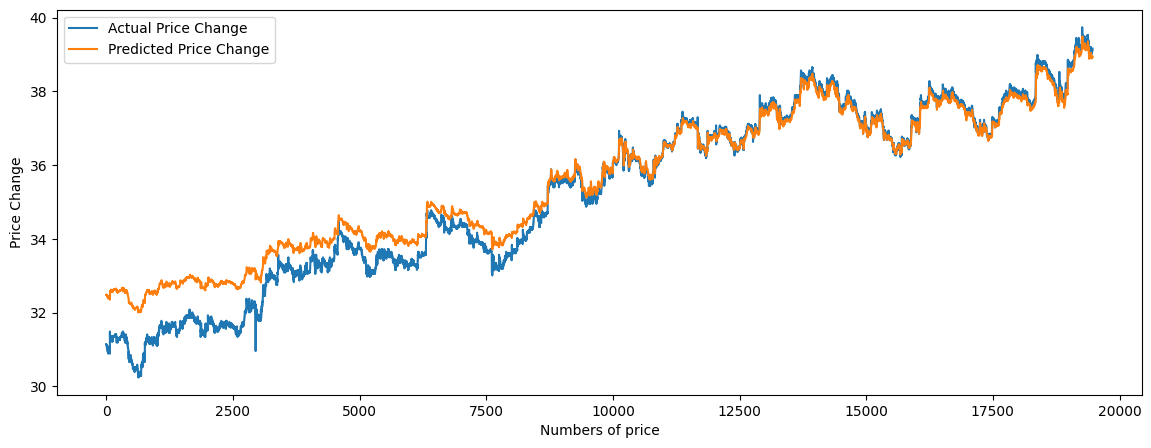

In [28]:
y_pred_FPT = evaluate_model(model_FPT, X_test_FPT, y_test_FPT)
plot_predictions(y_test_FPT, y_pred_FPT)

# Predict price of PNJ's Stock

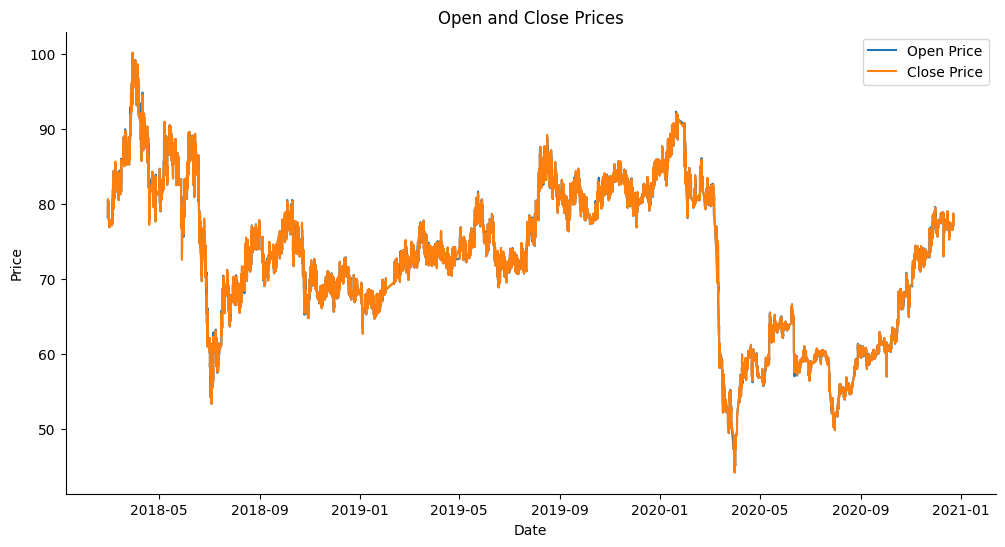

In [14]:
#Create data for training and validation model
X_train_PNJ, X_test_PNJ, y_train_PNJ, y_test_PNJ = pipeline(url_PNJ, seq_length = 60)

In [15]:
input_shape = (seq_length, X_train_PNJ.shape[2])

In [32]:
model_PNJ = create_model_LSTM(input_shape, output_size) #Create model
model_PNJ.summary()
model_PNJ, history_PNJ = train_model(model_PNJ, X_train_PNJ, y_train_PNJ, validation_data=(X_test_PNJ, y_test_PNJ)) #Training model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 30)            4200      
                                                                 
 dropout_10 (Dropout)        (None, 60, 30)            0         
                                                                 
 lstm_11 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_11 (Dropout)        (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 11551 (45.12 KB)
Trainable params: 11551 (45.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
3132/31

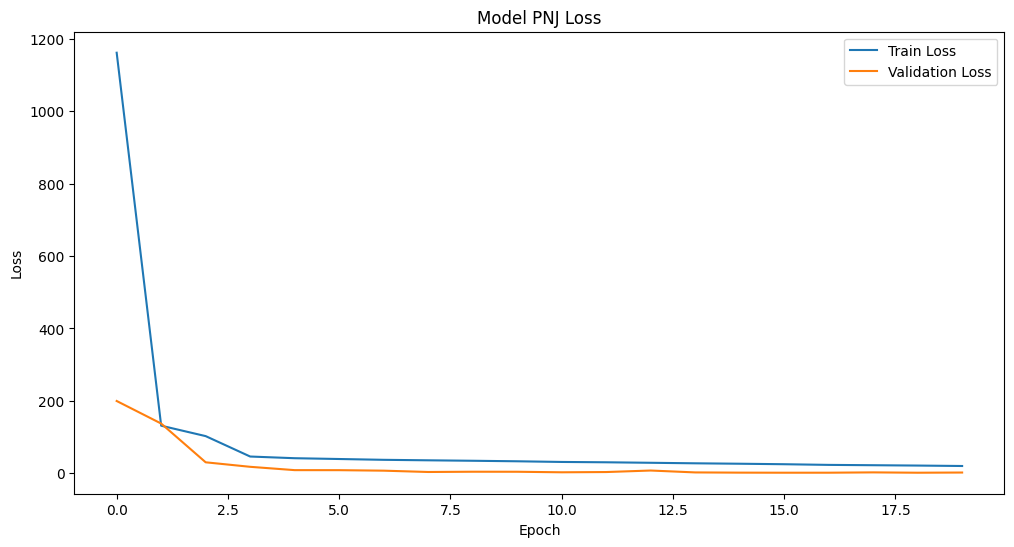

In [33]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_PNJ.history['loss'], label='Train Loss')
plt.plot(history_PNJ.history['val_loss'], label='Validation Loss')
plt.title('Model PNJ Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize PNJ price prediction

783/783 [==============================] - 3s 3ms/step
MAE: 1.1044833594051169, RMSE: 1.3861855107009473


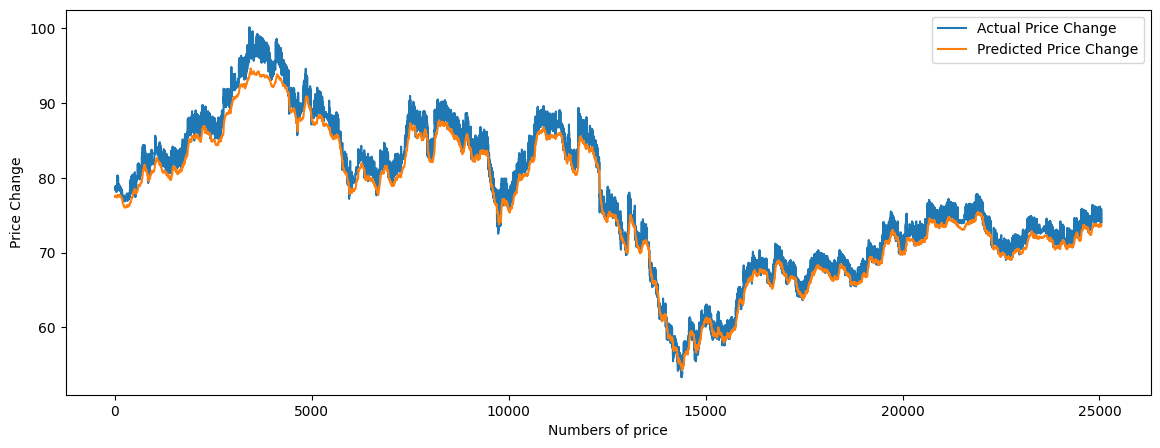

In [34]:
y_pred_PNJ = evaluate_model(model_PNJ, X_test_PNJ, y_test_PNJ)
plot_predictions(y_test_PNJ, y_pred_PNJ)

# Predict price of VIC's Stock

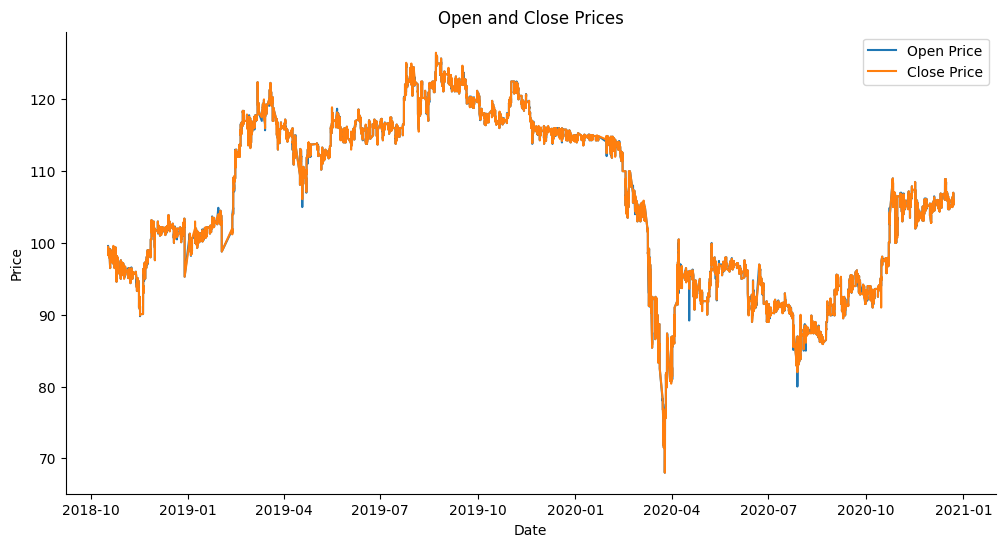

In [35]:
#Create data for training and validation model
X_train_VIC, X_test_VIC, y_train_VIC, y_test_VIC = pipeline(url_VIC, seq_length = 60)

In [36]:
input_shape = (seq_length, X_train_VIC.shape[2])

In [37]:
model_VIC = create_model_LSTM(input_shape, output_size) #Create model
model_VIC.summary()
model_VIC, history_VIC = train_model(model_VIC, X_train_VIC, y_train_VIC, validation_data=(X_test_VIC, y_test_VIC)) #Training model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 30)            4200      
                                                                 
 dropout_12 (Dropout)        (None, 60, 30)            0         
                                                                 
 lstm_13 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_13 (Dropout)        (None, 30)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 31        
                                                                 
Total params: 11551 (45.12 KB)
Trainable params: 11551 (45.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2531/25

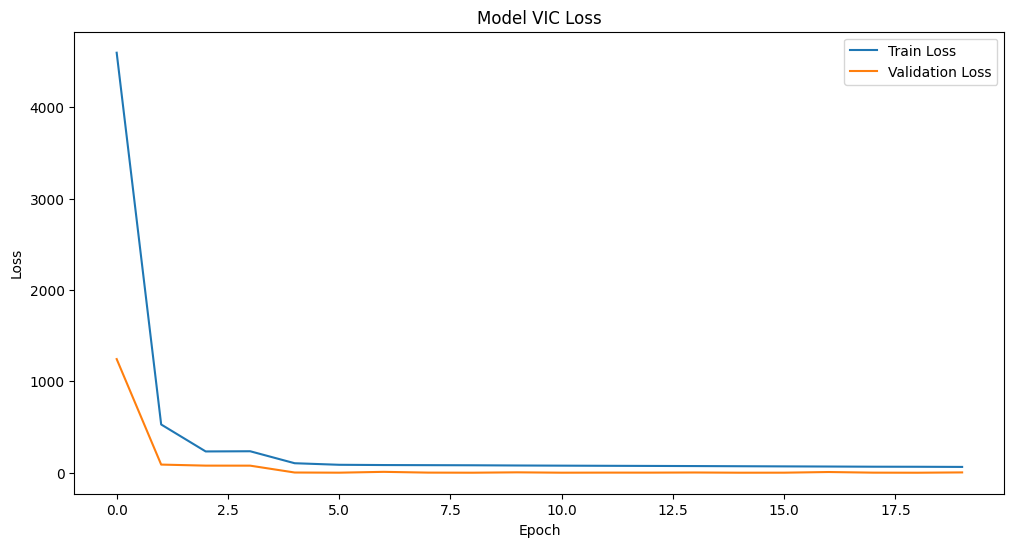

In [38]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_VIC.history['loss'], label='Train Loss')
plt.plot(history_VIC.history['val_loss'], label='Validation Loss')
plt.title('Model VIC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize VIC price prediction

633/633 [==============================] - 3s 3ms/step
MAE: 1.8559351342356105, RMSE: 1.8806206630723312


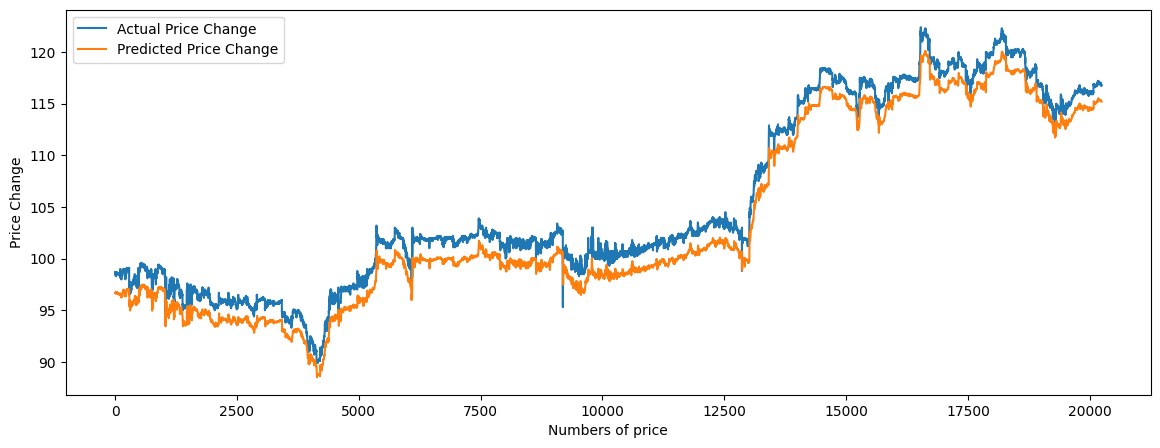

In [39]:
y_pred_VIC = evaluate_model(model_VIC, X_test_VIC, y_test_VIC)
plot_predictions(y_test_VIC, y_pred_VIC)

# Predict price of MSN's Stock

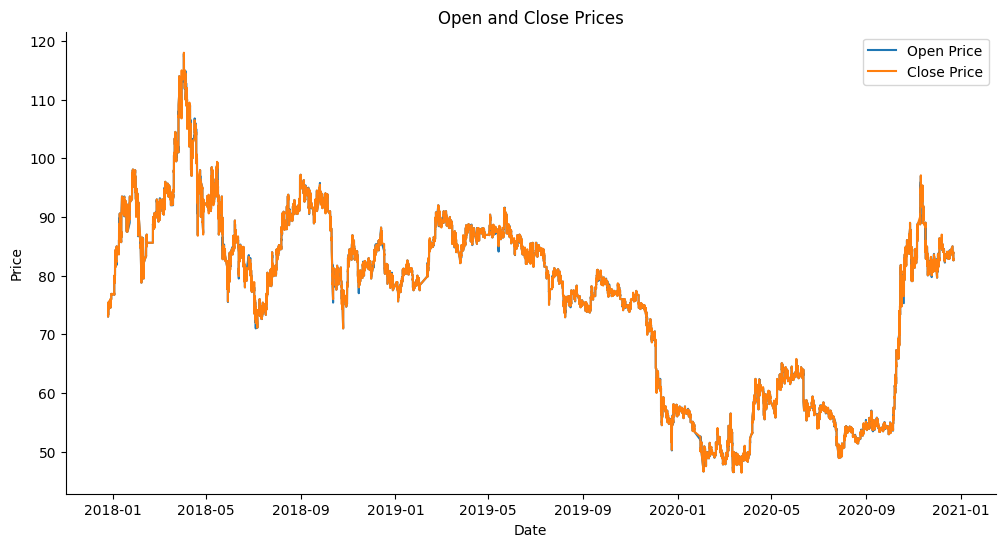

In [40]:
#Create data for training and validation model
X_train_MSN, X_test_MSN, y_train_MSN, y_test_MSN = pipeline(url_MSN, seq_length = 60)

In [41]:
input_shape = (seq_length, X_train_MSN.shape[2])

In [42]:
model_MSN = create_model_LSTM(input_shape, output_size) #Create model
model_MSN.summary()
model_MSN, history_MSN = train_model(model_MSN, X_train_MSN, y_train_MSN, validation_data=(X_test_MSN, y_test_MSN)) #Training model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 30)            4200      
                                                                 
 dropout_14 (Dropout)        (None, 60, 30)            0         
                                                                 
 lstm_15 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_15 (Dropout)        (None, 30)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 31        
                                                                 
Total params: 11551 (45.12 KB)
Trainable params: 11551 (45.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
3383/33

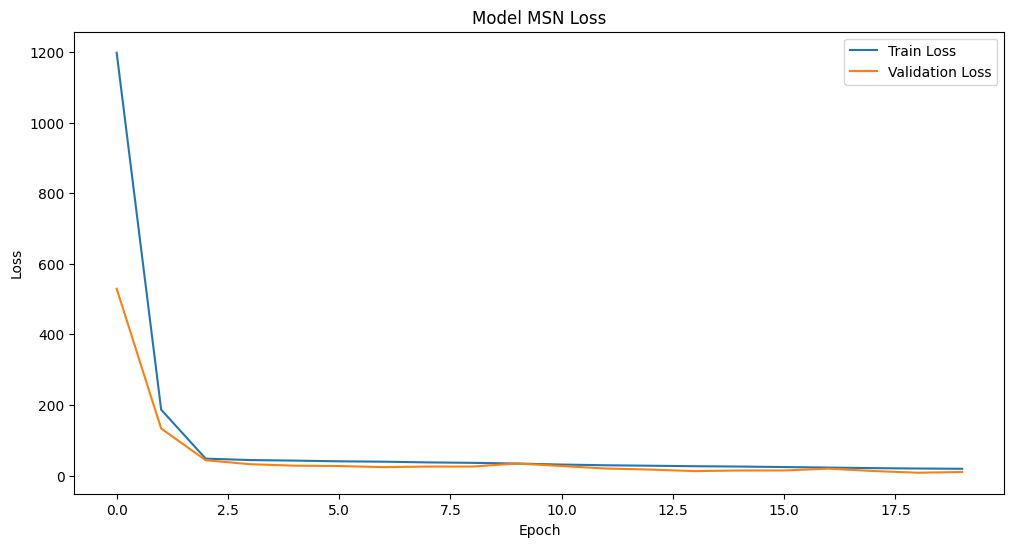

In [43]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_MSN.history['loss'], label='Train Loss')
plt.plot(history_MSN.history['val_loss'], label='Validation Loss')
plt.title('Model MSN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize MSN price prediction

846/846 [==============================] - 4s 4ms/step
MAE: 1.6741887987757025, RMSE: 3.168379837881172


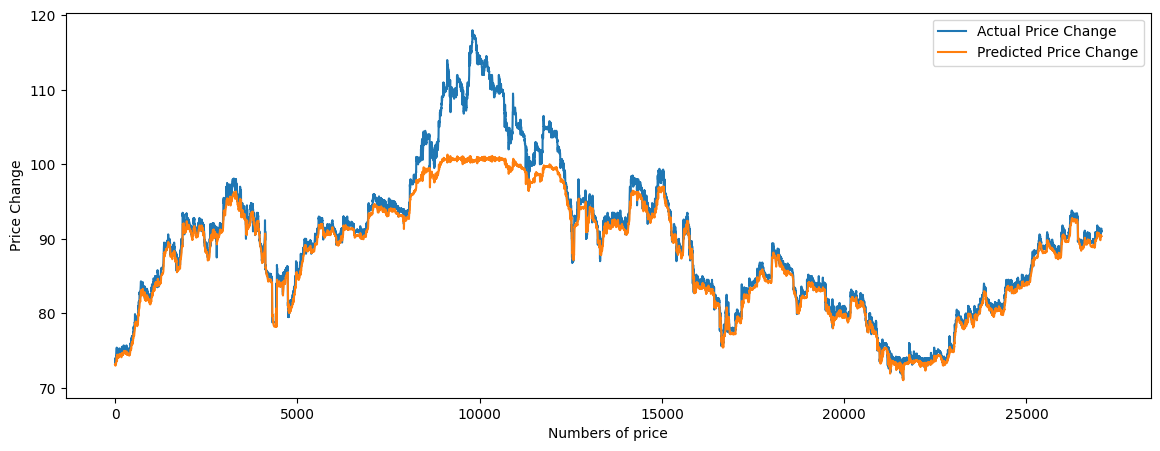

In [44]:
y_pred_MSN = evaluate_model(model_MSN, X_test_MSN, y_test_MSN)
plot_predictions(y_test_MSN, y_pred_MSN)

In [45]:
len(y_test_MSN)

27058